<a href="https://colab.research.google.com/github/Amelbnmbh/Data-wrangling-housing-/blob/main/Copy_of_AmelMosbah_WS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Processing Pipeline
## _Data wrangling_ with `python` ([`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/))



In this notebook, we will work with a real dataset, from the automated import of files to the preparation of data for _machine learning_ algorithms.

The _dataset_ contains real estate data from California, featuring variables such as population, median income, average housing prices, and more for each block group (the smallest administrative division in the U.S., comprising between 500 and 5,000 residents).

### Objectives

Our goal is to develop a predictive model for estimating the median housing price based on the other available information. This is a clear case of a supervised multivariate regression problem.

### Performance Measurement

Elle n'interviendra que dans le notebook suivant, celà dit, il convient d'avoir une idée des objectifs dès le début de projet.

Performance metrics will be addressed in the subsequent notebook; however, it's essential to establish our objectives from the project's outset. Ultimately, we aim to minimize the Root Mean Square Error (RMSE) and/or the Mean Absolute Error (MAE) of our model :

$$
\newcommand\x{\mathbf{x}}
\newcommand\X{\mathbf{X}}
\newcommand\y{\mathbf{y}}
\newcommand\Y{\mathbf{Y}}
\newcommand\RMSE{\mbox{RMSE}}
\newcommand\MAE{\mbox{MAE}}
$$
$$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$$

$$
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m}
$$

$h$ serves as the prediction function of the model.


### Environment Setup

Below are some imports and preliminary precautions for our work. It’s advisable to review them.
If necessary, create a block at the beginning to install all the required libraries by executing the following commands one at a time:
- pip install numpy
- pip install pandas
- pip install sklearn

In [1]:
# Imports
import numpy as np
import os

from numpy.random import default_rng

# Ensure notebook stability between executions
random = default_rng(42)

# Display plots directly in the notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Set plot parameters for better readability
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Define the directory to save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)  # Ensure this folder exists

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Data Import
It is important to automate the data import process. We will implement a function that will:

* Download the archive
* Extract the files

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    filepath = HOUSING_PATH + '/housing.tgz'
    urllib.request.urlretrieve(HOUSING_URL, filepath)
    untar_file(filepath)

def untar_file(file):
    tf = tarfile.open(file)
    tf.extractall(path=HOUSING_PATH)

We can now import the data: :

In [3]:
fetch_housing_data()

### Loading Data into Memory
Similarly, we will create a function using `pandas` that loads the data into memory as a `pandas DataFrame`.

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Quick Look
1. Let's take a look at the first few rows of our `DataFrame` using the `head()` method:




In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


2. Now let's use the `info()` method to get a description of the dataset:

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


3. The `value_counts()` function allows us to find out, for example, the number of different values in a Series such as `ocean_proximity`, which appears to be categorical:

In [8]:
housing.ocean_proximity.value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


4. The `describe()`method provides a statistical summary of the numerical values:


In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


5. We can use the `hist()` function along with `Matplotlib` to display a histogram for each numerical attribute.

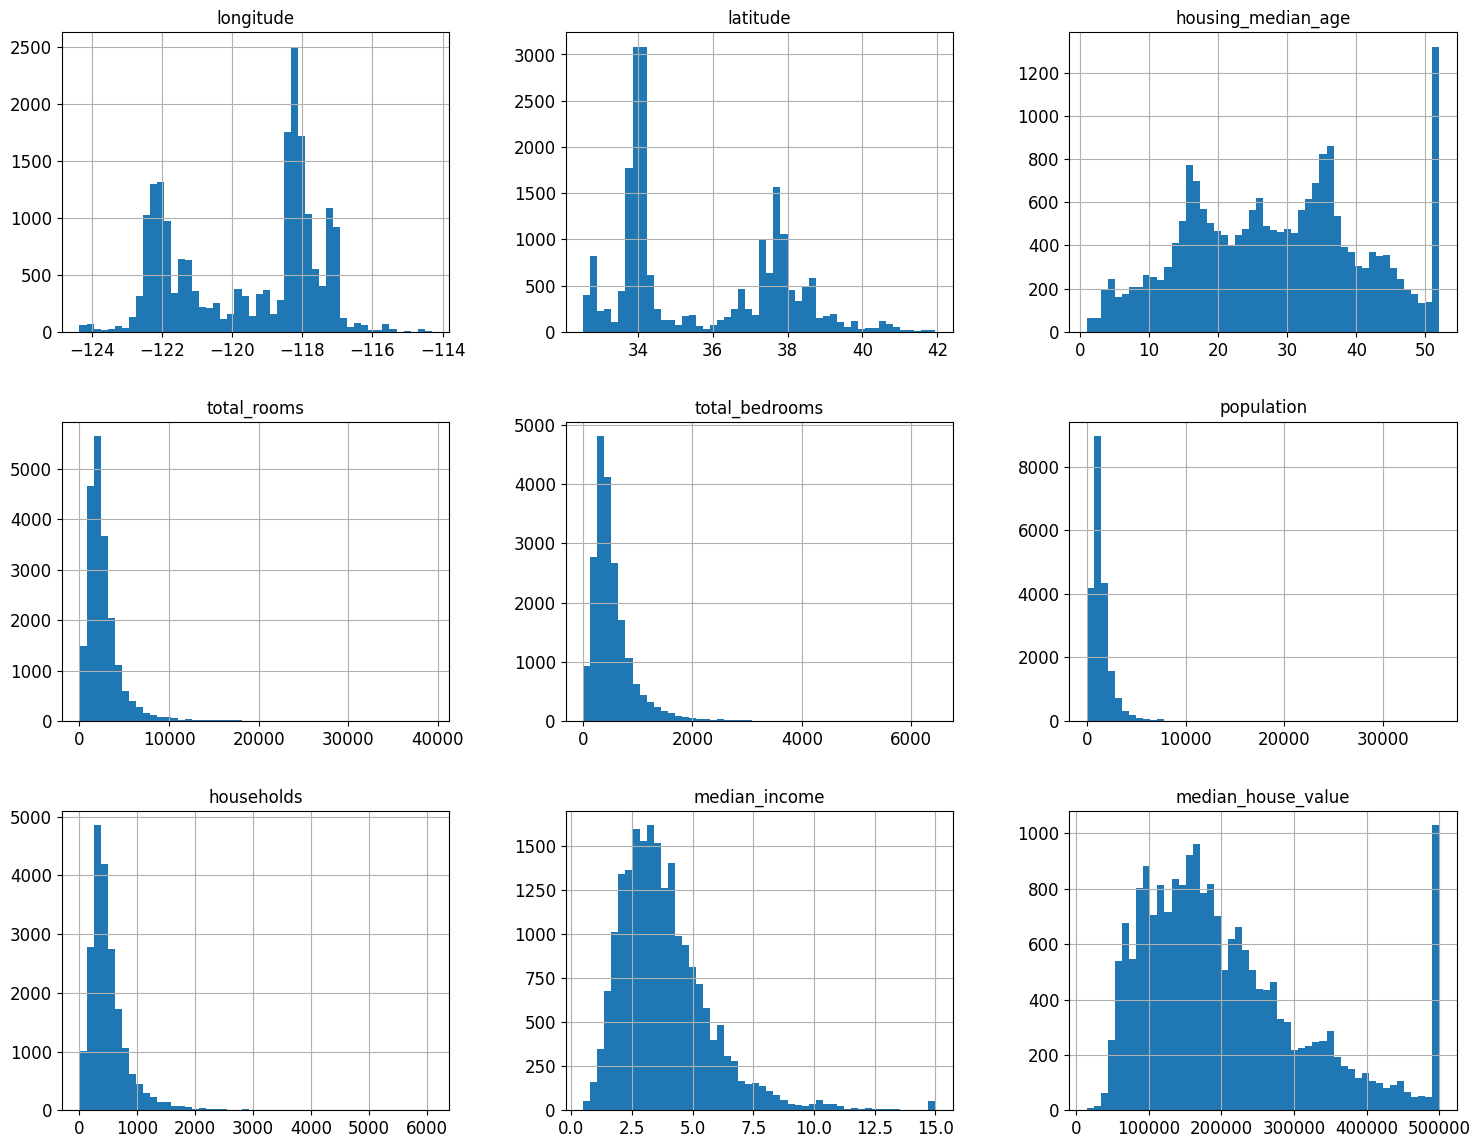

In [10]:
housing.hist(bins=50, figsize=(18, 14))
plt.show()

#### Remarks: :
* `median_income` is not in U.S. dollars. Upon consulting the authors of the dataset, we learn that the values have been scaled and capped between 0.49999 and 15.0001, meaning that all values below 0.49999 are recorded as 0.49999, and all values above 15.0001 are recorded as 15.0001.
* `housing_median_age` and `median_house_value` are also capped. This poses an issue for the latter feature since it is our target variable. Our model will need to learn to respect this capping, and the client must be informed: does this limit meet their needs? If not, we may consider collecting additional data or removing the affected values from the dataset.
* The scales are very different from one feature to another. Scaling will likely be necessary to achieve a performant model.
* Several histograms are tail-heavy, while machine learning algorithms generally perform better with bell-shaped distributions

### Poor Practices Described in the Prosit
Here’s what was done by in the prosit:
- Removed variables with missing data.
- Removed qualitative variables.
- Worked with the complete dataset, which does not allow for testing the quality of the results obtained (especially if classification or regression is intended).

By removing variables, important information may have been lost.

#### Hierarchical Ascending Classification

Don’t be surprised by the time it takes before the results are displayed. We are using the entire dataset, and the algorithm is not the most suitable for large datasets. Note that the algorithm uses Euclidean distance to measure the distance between two points (block groups at the business level), and the Ward method is employed to minimize the distance between points within the same cluster.


In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

X = housing.copy() # A new copy of data set
X.drop("ocean_proximity", axis=1, inplace=True) # Not numerical
X.drop("total_bedrooms", axis=1, inplace=True) # Missing values
X.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


Construction and Display of the Resulting Dendrogram:

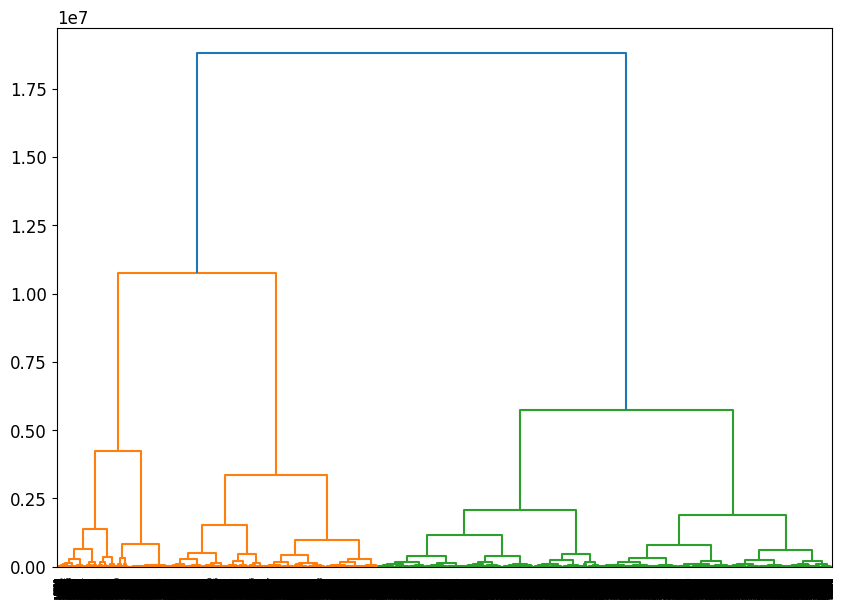

In [12]:
plt.figure(figsize=(10, 7))
dendrogram(linkage(X, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

Representation of the two selected classes (n_clusters) based on longitude and latitude. In relation to the dendrogram, we remove the branches drawn in blue.

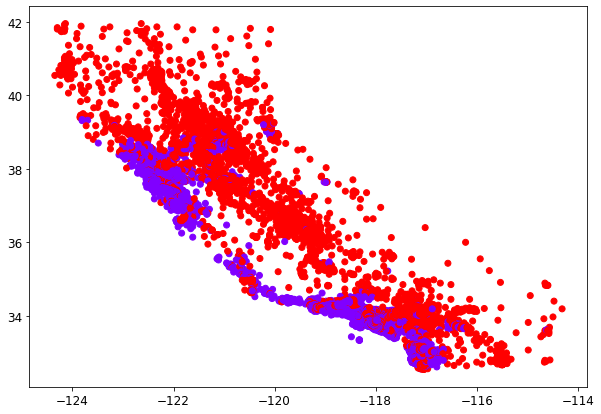

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
plt.figure(figsize=(10, 7))
plt.scatter(X['longitude'],X['latitude'], c=cluster.labels_, cmap='rainbow')
plt.show()

### Creating a Test Set

#### Random Test Set

We have observed this dataset enough; it is now time to reserve a test sample. Indeed, your brain, a remarkable learning machine, is already beginning to establish patterns. This could bias the process leading to model selection and result in overfitting. The test set should only be used when we are close to our goal and sufficiently convinced that the established model is the right one. Otherwise, we risk engaging in data snooping. A note for later:

> **No data snooping!**

Creating a test set is straightforward: randomly set aside 20% of the data.

The example code below illustrates the approach, but the scikit-learn framework provides a function for this purpose. We utilize the [`numpy.random`](https://numpy.org/doc/stable/reference/random/index.html) object, which generates a sequence of random bits that is used to produce random numbers.

During the development phase, it is customary to manually define a seed for this random sequence to reproduce the same behavior across different runs of our script. This allows us to validate our development without the sequence of random numbers complicating the interpretation between executions. The value commonly used for this seed is [42](https://medium.com/@leticia.b/the-story-of-seed-42-874953452b94) (refer back to the "Environment Preparation" section to see this in action).


In [13]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In practice, some libraries have not yet adopted the recently integrated random bit sequence generators in NumPy, which can lead to behavior in your script that is harder to interpret from one execution to another.

#### Using a Hash Function

Below, we define a function `split_train_test_by_id` that constructs a test set by hashing a unique identifier for each row (e.g., the row number). The result of this hash is mapped to the boolean set \(\{0,1\}\) while maintaining the specified ratio to determine the destination of the record (test or training).


In [15]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Using `scikit-learn`

The machine learning library [`scikit-learn`](https://scikit-learn.org/) offers a function called [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) that performs this task. Its use is highly recommended now that we understand how it works.


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
test_set, train_set = train_test_split(housing, test_size=0.3, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7061,-118.02,33.93,35.0,2400.0,398.0,1218.0,408.0,4.1312,193800.0,<1H OCEAN
14689,-117.09,32.79,20.0,2183.0,534.0,999.0,496.0,2.8631,169700.0,NEAR OCEAN
17323,-120.14,34.59,24.0,1601.0,282.0,731.0,285.0,4.2026,259800.0,NEAR OCEAN
10056,-121.00,39.26,14.0,810.0,151.0,302.0,138.0,3.1094,136100.0,INLAND
15750,-122.45,37.77,52.0,3188.0,708.0,1526.0,664.0,3.3068,500001.0,NEAR BAY


It is essential to ensure that no statistical bias is introduced and to adhere to [_stratified sampling_](https://en.wikipedia.org/wiki/Stratified_sampling). For example, in our case, we will strive to achieve a representative distribution of `median_income`. To avoid under-representation or over-representation biases, we aim to have a limited number of strata (which we will prefer to keep fairly broad).


#### Stratified Sampling

After discussions with industry experts, we are convinced that the average income is a key variable. We want to perform sampling where the training and test sets respect the representation proportions of the different income categories. To achieve this, we first create a categorical variable `income_cat` as a counterpart to the numerical variable `median_income`.


In [19]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

<ipython-input-19-509a4034b91c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false


We can observe the counts of each category.


<Axes: >

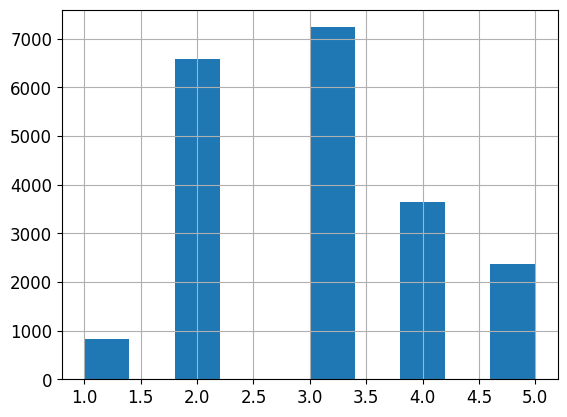

In [20]:
housing["income_cat"].hist()

We can now use [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to sample the dataset while respecting our constraint:


In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

[12655 15502  2908 ... 19263 19140 19773] [ 5241 17352  3505 ... 17223 10786  3965]


<Axes: >

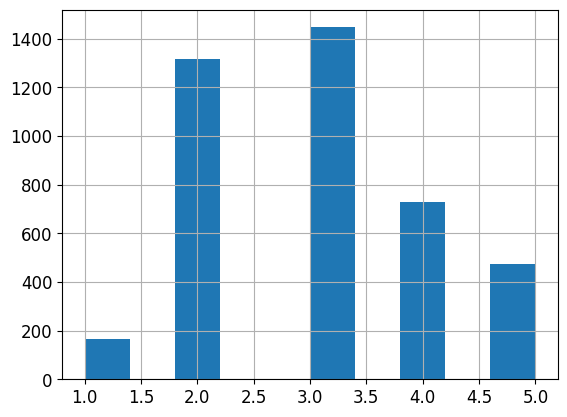

In [22]:
strat_test_set["income_cat"].hist()

Our sampling accurately reflects the proportions of the initial dataset. We no longer need the `income_cat` column, so we will remove it using [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).


In [23]:
for set_ in (strat_train_set, strat_test_set):
  set_ = set_.drop("income_cat", axis=1, inplace=True)

In [24]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


**Note:** If the dataset were larger, we might need to create an exploration set. However, this is not necessary in this case.


### Exploring the Dataset

With our test set established, we can begin the exploration. We will work on a copy of the training set to avoid any unpleasant surprises.


In [25]:
housing = strat_train_set.copy()

#### Visualizing Geographical Data

The [`matplotlib`](https://matplotlib.org/) library allows us to represent data in graphical form. You can get started with it through this [tutorial](https://www.python-course.eu/matplotlib.php).

Since we have the geographical coordinates of our records, we would like to plot them on a map:


<Axes: xlabel='longitude', ylabel='latitude'>

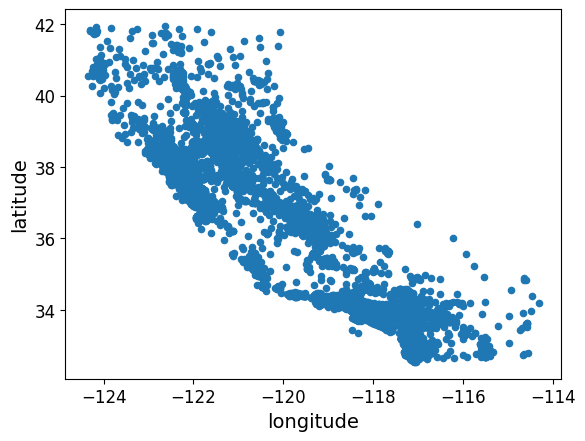

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude")

The current visualization is not very readable, so we would like to adjust the transparency of the points to highlight the density of points.


<Axes: xlabel='longitude', ylabel='latitude'>

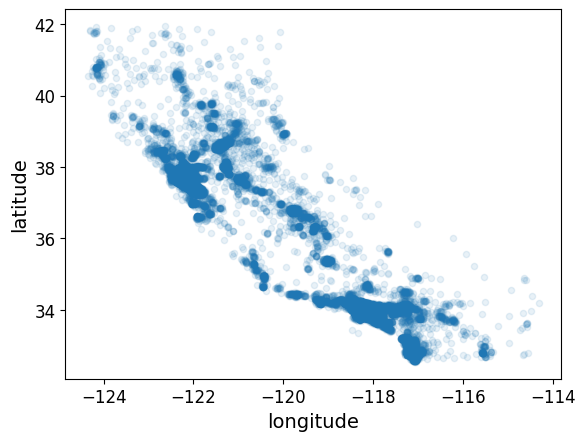

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can freely vary the size of our markers (using the `s` option) and their color (using the `c` option: we will use a predefined colormap named `jet`). Here, we want to differentiate the areas based on their population and average income.


Saving figure housing_prices_scatterplot


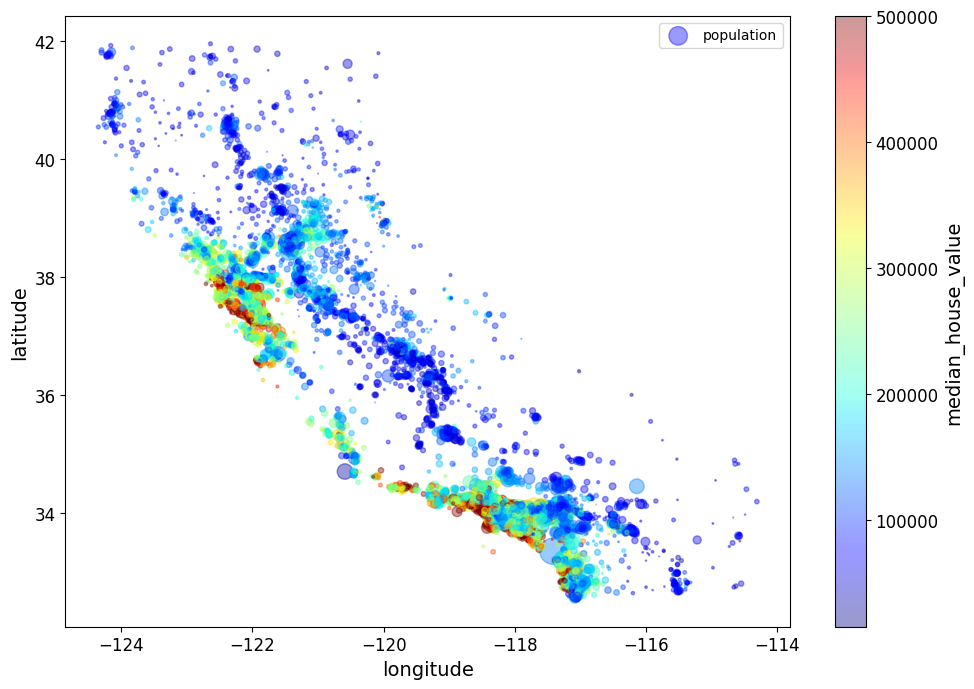

In [29]:
# Create the directory if it doesn't exist
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)  # This creates the directory if it doesn't exist

# Your plotting code
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

# Save the figure
save_fig("housing_prices_scatterplot")  # Now this should work without an error

We observe that geographical location is significant. We can imagine that the average value of a house is correlated with proximity to the ocean. Additionally, a clustering algorithm could yield interesting results.

If we wanted to visualize other geographical data, we could use [another color palette](https://matplotlib.org/examples/color/colormaps_reference.html) based on what we wish to demonstrate. In the previous example, the colors were displayed on a warm/cool axis; a randomly chosen palette like `cubehelix` would have yielded a less interpretable result. Color should not be overlooked when it comes to highlighting an idea.


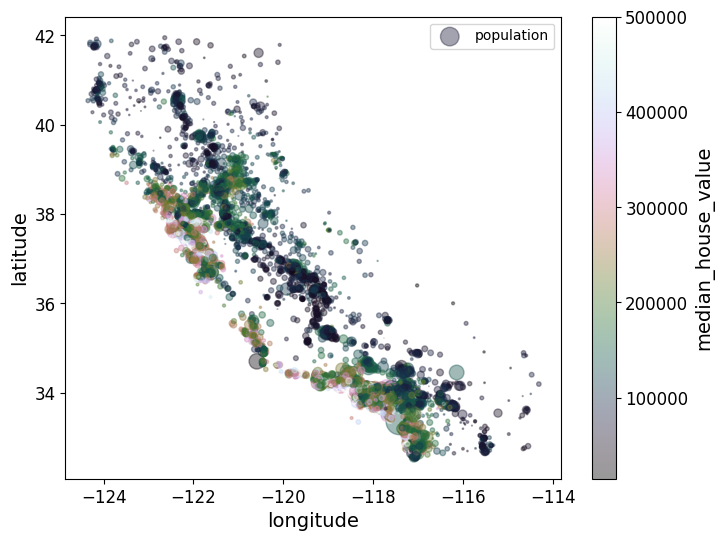

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(8,6),
    c="median_house_value", cmap=plt.get_cmap("cubehelix"), colorbar=True,
    sharex=False)
plt.legend()

#### Correlation Analysis

Variables within a dataset can be related to one another (more or less strongly, positively or negatively), which is why we calculate their [correlation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)).


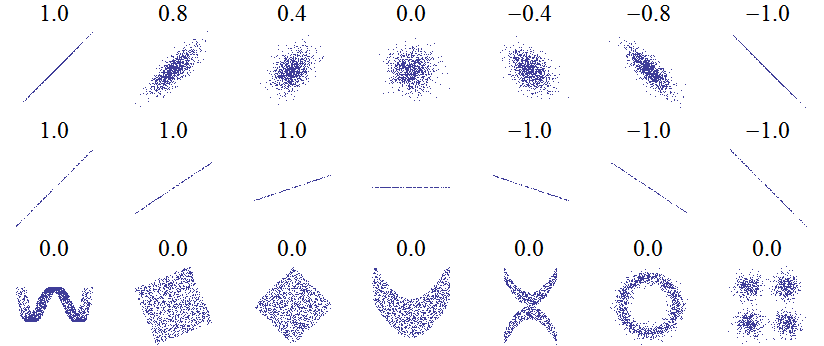

In [31]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png")

For a small dataset like ours, we can calculate the correlation matrix using [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) and display a series, for example, the one corresponding to the variable `median_income`:


In [32]:
correlation_matrix = housing.select_dtypes(include=['float64', 'int64']).corr()
median_income_corr = correlation_matrix['median_income']
median_income_corr

,median_income
longitude,-0.019615
latitude,-0.075146
housing_median_age,-0.111315
total_rooms,0.200133
total_bedrooms,-0.009643
population,0.002421
households,0.010869
median_income,1.000000
median_house_value,0.687151


The [`scatter_matrix`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) function allows us to visualize the relationships between variables, along with a bonus histogram for each variable on the diagonal:


Saving figure scatter_matrix_plot


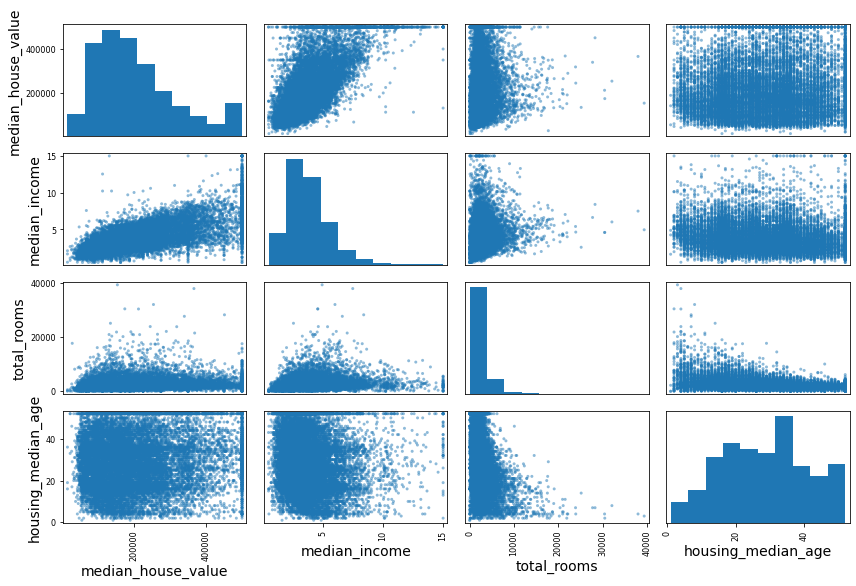

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

We can already observe a strong positive correlation between `median_income` and `median_house_value`. This is promising.

Let’s take a closer look at this candidate:


Saving figure income_vs_house_value_scatterplot


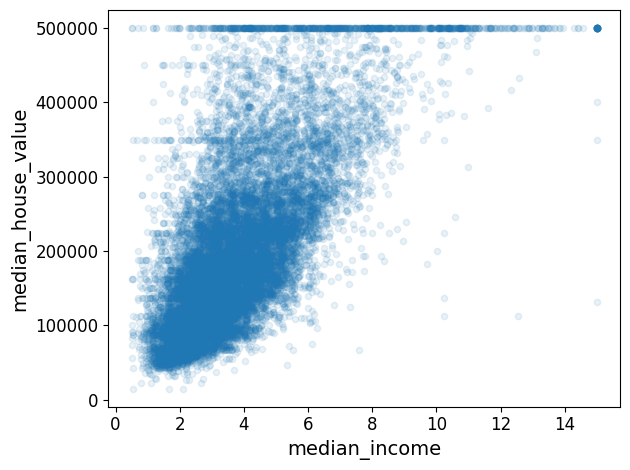

In [33]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

save_fig("income_vs_house_value_scatterplot")

We can see some areas for improvement:

- The horizontal lines in the last graph could correspond to the responses in a questionnaire. It would be reasonable to remove the corresponding values if we wanted to achieve an optimal result.
- Some distributions are tail-heavy; we could attempt to transform them, possibly by using a logarithm.
- We also want to combine certain attributes. For instance, it seems logical to relate the number of rooms in the district (`total_rooms`) to the total number of housing units in that district (`households`).



#### Combining Attributes

As suggested earlier, we will create new variables: `rooms_per_household`, `bedrooms_per_room`, and `population_per_household`. We will then visualize their correlation with `median_house_value`.


In [66]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [67]:
correlation_matrix = housing.select_dtypes(include=['float64', 'int64']).corr()
median_income_corr = correlation_matrix['median_income'].sort_values(ascending=False)
median_income_corr

,median_income
median_income,1.000000
rooms_per_household,0.311528
total_rooms,0.200133
population_per_household,0.021815
households,0.010869
population,0.002421
total_bedrooms,-0.009643
longitude,-0.019615
latitude,-0.075146
housing_median_age,-0.111315


Not bad! We observe a fairly strong negative correlation with `bedrooms_per_room`.
Next, we will prepare the data for machine learning.


## Data Preparation for Machine Learning Algorithms

It is essential to script this preparation for several reasons:
* To make it reproducible, for example, if we obtain a newer version of the original dataset.
* To build a library of utilities.
* To enable these transformations to be used in real-time in production without human intervention.
* To conduct benchmarks between different preparation strategies.

We will begin by splitting the dataset into two parts: the target variables, or labels, often denoted as $\Y$ (in this case, just $\y$), and the other variables denoted as $\X$. This will result in `housing_labels` and `housing`.


In [36]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning

##### Missing Values in `total_bedrooms`

As we observed earlier by calling the `info()` method, the feature `total_bedrooms` contains missing values.


In [37]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


We have several options for handling missing values:
1. Remove the instance.
2. Remove the feature.
3. Replace with a value (0, median, etc.).

We could use [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna), [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html#pandas.DataFrame.drop), or [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) for these tasks.


In [ ]:
# option 1 :
# housing.dropna(subset=["total_bedrooms"])
# option 2 :
# housing.drop("total_bedrooms", axis=1)
# option 3 :
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

We will test these options on the affected sample `sample_incomplete_rows`.


In [68]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY,4.707668,NaN,1.317891
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN,4.537074,NaN,3.947896
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN,5.826196,NaN,2.403023
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN,4.448980,NaN,2.840136
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN,6.835417,NaN,2.385417


In [69]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household


In [40]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [41]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

<ipython-input-41-edae141c0e15>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


For convenience, `scikit-learn` offers a dedicated class for this type of processing: [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).


In [70]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

**Note:** This strategy only applies to numerical variables, so we need to drop the others for processing.


In [71]:
#housing_num = housing.drop('ocean_proximity', axis=1)
# Plus général :
housing_num = housing.select_dtypes(include=[np.number])

We can now train the `Imputer` using the `fit()` method.


In [72]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

> The API of `scikit-learn` is designed such that objects, whether they are estimators, transformers, or predictors, share a common intuitive syntax. For further reading, it is worthwhile to explore the paper *API design for machine learning software: experiences from the scikit-learn project* by Buitinck et al. [here](https://hal.inria.fr/hal-00856511/file/paper.pdf).


The `Imputer` has calculated the median for each variable and stored it in its `statistics_` attribute.


In [73]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

In [74]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  2.03027043e-01,  2.81766108e+00])

We can then transform the data using the `transform()` method of the `Imputer`:


In [75]:
imputer.transform(housing_num)

array([[-121.46      ,   38.52      ,   29.        , ...,    5.48583569,
           0.20578363,    3.16855524],
       [-117.23      ,   33.09      ,    7.        , ...,    6.92708333,
           0.16071429,    2.62369792],
       [-119.04      ,   35.37      ,   44.        , ...,    5.39333333,
           0.19159456,    2.22333333],
       ...,
       [-122.72      ,   38.44      ,   48.        , ...,    4.11046512,
           0.23479491,    2.6627907 ],
       [-122.7       ,   38.31      ,   14.        , ...,    6.29740519,
           0.18383518,    2.41117764],
       [-122.14      ,   39.97      ,   27.        , ...,    5.47715736,
           0.20574606,    3.17258883]])

The result is a [`NumPy`](http://www.numpy.org/) [`array`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.array.html). We will convert it back into a `DataFrame`, retrieving the column names from `housing_num`.


In [76]:
data=pd.DataFrame(housing_num)
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,6.297405,0.183835,2.411178


### Textual and Categorical Attributes

We will now focus on the categorical variables.

#### Encoding


In [77]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


As machine learning algorithms work better with numerical data, we will map these categories to numbers using `OrdinalEncoder`. We will use the `fit_transform` method, which combines `fit` and `transform`, as its name suggests.


In [78]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

The `encoder` provides access to the mapping of the categories:


In [79]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

> **Caution!** Some machine learning algorithms may interpret numerical values such as $1$ and $2$ as being closer to each other than $1$ is to $4$. This assumption does not hold true here if we simply map categories to `[0, 1, 2, 3, 4]`. One-hot encoding addresses this issue. Each category will give rise to a new boolean variable.

### One-hot Encoding

When a variable is not ordinal, this solution will create additional variables in the dataset to represent each category. In our dataset, this can be a valid choice, or we can use the previous approach by specifying the order of categories. For example: 'INLAND' > '<1H OCEAN' > 'NEAR OCEAN' > 'NEAR BAY' > 'ISLAND'. Domain expertise can assist in making such choices based on the context.


In [80]:
from sklearn.preprocessing import OneHotEncoder

We use the `fit_transform` method of the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which returns a sparse matrix. This compressed version can be revealed using the `toarray()` method.


In [81]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array creux par défaut

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [82]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

An alternative is to use the `sparse` option of the encoder.


In [83]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array dense

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

We can access the categories via the `categories_` attribute of our encoder.


In [84]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### Transformations _ad hoc_

Sometimes, it will be necessary to implement our own transformations. Staying consistent with the `scikit-learn` API will allow us to build homogeneous processing pipelines.

Since `scikit-learn` is based on duck typing, implementing a transformer will involve creating a class with the following methods:
- `fit()` (usually returning `self`)
- `transform()`
- `fit_transform()` (automatically obtained by adding `TransformerMixin` to the base classes)

Adding the `BaseEstimator` class to the base classes will facilitate automated hyperparameter tuning later on. It adds the `get_params` and `set_params` methods, provided that a fixed number of parameters is defined in the constructor (avoiding `*args` and `**kwargs`).

The example below serves to create the combined variables:


In [90]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]  # Calculate bedrooms per room
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

> **Note:** In this case, our transformer has a single hyperparameter, `add_bedrooms_per_room`. It will be easy to modify our processing chain to determine whether or not this parameter should be included. Parameters allow for delaying or even automating decisions of this nature.


In [91]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [92]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 3.168555240793201, 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 2.6236979166666665, 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 2.223333333333333, 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 2.6627906976744184,
        4.1104651162790695, 2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 2.411177644710579, 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 3.1725888324873095, 5.477157360406092,
        3.1725888324873095]], dtype=object)

We can reconstruct a `DataFrame` with headers.


In [93]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,0.205784,3.168555,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,0.160714,2.623698,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,0.191595,2.223333,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,0.276505,1.859213,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,0.182692,3.167241,6.096552,3.167241


##### _Feature scaling_

Machine learning algorithms do not perform well when the features have very different scales (e.g., `number_of_rooms` between 0 and 40,000 while `median_income` is between 0 and 15). The strategies to address this are: _min-max scaling_ and _standardization_.

* **Min-max scaling**: maps [min, max] to [0, 1] ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)).
* **Standardization**: maps the mean to zero with unit variance ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).

The second option is less sensitive to [_outliers_](https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante).

> It is important to scale based on the training data only.


##### Transformation Pipeline

We want to create a transformer that combines all the others (executed in the correct order). For example, for the numerical attributes:


In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

It would be even better not to have to manually extract the numerical values. We would like to feed the pipeline directly with the initial `DataFrame`. We will use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to create the branching.


In [95]:
from sklearn.compose import ColumnTransformer

In [96]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [97]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [98]:
housing_prepared.shape

(16512, 19)

We have completed the data preparation step. Now, define your pipeline to prepare the data so that it is as suitable as possible for executing the K-Means algorithm. After that, you can proceed to the training!
